# GripPrint
- Unique "fingerprint" based on how users grip and interact with the dualsense controller.


### Model 1 Minimuan validation model- ontable or onhand


#### Collect data

In [6]:
# define a function to check the connection of the dualsense controller

def check_controller_connection():
    try:
        dualsense = ds.pydualsense()
        # Try to find and open the device
        device = dualsense._pydualsense__find_device()  # Access private method with name mangling
        if device:
            print("✅ Controller connected")
            connected = True
        else:
            print("❌ Controller not connected")
            connected = False
            
    except Exception as e:
        print("❌ Controller not connected")
        connected = False
    finally:
        if 'device' in locals():
            try:
                device.close()
            except:
                pass
    
    return connected



print("Is the controller connected?", check_controller_connection())

✅ Controller connected
Is the controller connected? True


In [11]:
# define a function to collect data from the dualsense controller with two labels: ontable and onhand
# save the data to a csv file

import os
import time
import pandas as pd
import pydualsense as ds

table_colunm=["timestamp", "gyroscope_pitch", "gyroscope_yaw", "gyroscope_roll", "accelerometer_x", "accelerometer_y", "accelerometer_z", "session_id", "label"]


def simple_data_collection(label: str, session_count: int = 500, collection_duration: int = 100000, csvfile_name:str="Simple_data.csv"):
    # parameters:
    # label: the label of the data collection
    # session_time: the time segment of the data collection in milliseconds
    # collection_duration: the duration of the data collection in milliseconds

    dualsense = ds.pydualsense()
    dualsense.init()    

    #  get the timestamp of the data collection
    timestamp = time.time()

    #  get the inertial data from the dualsense controller
    inertial_data = []
    start_time = time.time()
    session_id = int(time.time())  # Initial session_id
    data_count = 0  # Counter for collected data points
    
    while (time.time() - start_time) * 1000 < collection_duration:
        current_time = time.time()
        
        # Get sensor data from dualsense
        gyro = dualsense.state.gyro
        accel = dualsense.state.accelerometer
        
        # Create a data point
        data_point = [
            current_time,
            gyro.Pitch, gyro.Yaw, gyro.Roll,
            accel.X, accel.Y, accel.Z,
            session_id,
            label
        ]

        # update the data point in the console in one line 
        print(f"Data points: {data_count}, Session ID: {session_id}, Data: {data_point}", end='\r')

        #  append the data point to the inertial data
        inertial_data.append(data_point)
        
        # Increment data counter and update session_id every 500 data points
        data_count += 1
        if data_count % session_count == 0:
            session_id += 1
            
        time.sleep(0.001)  # Small delay to prevent overwhelming the controller
    
    #  save the inertial data to a csv file
    df = pd.DataFrame(inertial_data, columns=table_colunm)
    
    

 
    # Use csvfile_name as the target file
    if os.path.exists(csvfile_name):
        # Append data without header
        df.to_csv(csvfile_name, mode='a', header=False, index=False)
        print(f'Data appended to existing {csvfile_name}')
    else:
        # Create new file with header
        df.to_csv(csvfile_name, index=False)
        print(f'New file {csvfile_name} created')

    dualsense.close()


# define a function to start the invoke the simple_data_collection 
# Second cell - Define the function
def collect_both_positions():
    file_index=int(time.time())
    csvfile_name=f"sample_data{file_index}.csv"
    # First collection - Table position
    input("Press Enter when ready to collect data for TABLE position (controller flat on table)...")
    print("Starting data collection for TABLE position in 3 seconds...")
    time.sleep(1)
    print("2...")
    time.sleep(1)
    print("1...")
    time.sleep(1)
    print("Recording...")
    simple_data_collection(label='table' ,csvfile_name=csvfile_name)
    print("Table position data collection completed!")
    
    # Short break between collections
    print("\nTaking a short break before next position...")
    time.sleep(3)
    
    # Second collection - Hand position
    input("\nPress Enter when ready to collect data for HAND position (controller held in hand)...")
    print("Starting data collection for HAND position in 3 seconds...")
    time.sleep(1)
    print("2...")
    time.sleep(1)
    print("1...")
    time.sleep(1)
    print("Recording...")
    simple_data_collection(label='hand',csvfile_name=csvfile_name)
    print("Hand position data collection completed!")
    
    print("\nAll data collection completed successfully!")







In [12]:
# perform the data collection
collect_both_positions()

Starting data collection for TABLE position in 3 seconds...
2...
1...
Recording...
New file sample_data1731663712.csv created, Data: [1731663816.8790996, -417, 8049, 1121, -1, 2, 10, 1731663903, 'table']]
Table position data collection completed!

Taking a short break before next position...
Starting data collection for HAND position in 3 seconds...
2...
1...
Recording...
Data appended to existing sample_data1731663712.csv1731663927.4338663, -903, 937, -8362, -1, -23, 314, 1731664014, 'hand']']]]]]]]]
Hand position data collection completed!

All data collection completed successfully!


##### table for describing the data table column:

| Column Name | Description | Data Type | Unit/Range | 
|------------|-------------|-----------|------------| 
| timestamp | Time when the data was recorded | Numeric | Unix timestamp or datetime |
 | gyroscope_pitch | Rotation around the X-axis (front-to-back tilt) | Numeric | Degrees or Radians | 
 | gyroscope_yaw | Rotation around the Y-axis (left-to-right turn) | Numeric | Degrees or Radians | 
 | gyroscope_roll | Rotation around the Z-axis (side-to-side tilt) | Numeric | Degrees or Radians | 
 | accelerometer_x | Linear acceleration along X-axis (left/right) | Numeric | m/s² or g-force | 
 | accelerometer_y | Linear acceleration along Y-axis (forward/backward) | Numeric | m/s² or g-force |
  | accelerometer_z | Linear acceleration along Z-axis (up/down) | Numeric | m/s² or g-force | 
  | session_id | Unique identifier for each recording session | String/Integer | Identifier, collect 500 rows as one session |
   | label | Classification label or target variable | String/Integer | Class identifier  Binary table/hand |

### 3 model comapre for the sample data 


In [13]:
# csv file ready
data_csv = 'sample_data1731663712.csv'


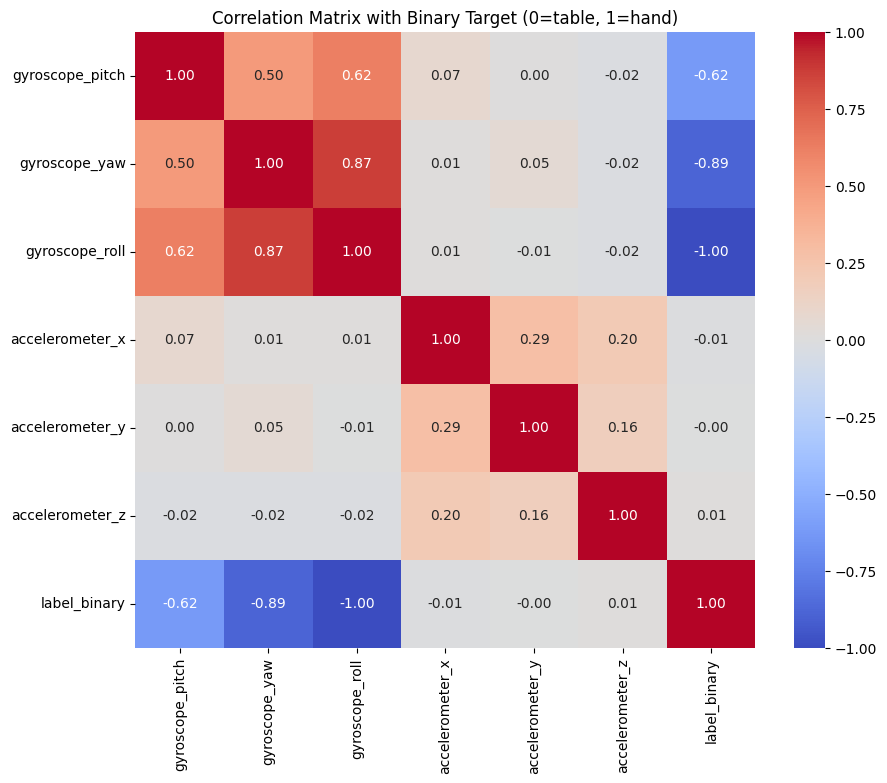


Interpretation:
• Values close to 1: Strong positive correlation
• Values close to -1: Strong negative correlation
• Values close to 0: Little to no correlation

Target encoding:
• 0 = table position
• 1 = hand position


In [19]:
# analysis the correlation between the features
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_df = pd.read_csv(data_csv)



# Define features and label
features = data_df.columns[:-1]  # all columns except label

# First convert the label column to binary (0 for 'table', 1 for 'hand')
data_df['label_binary'] = (data_df['label'] == 'hand').astype(int)

# Calculate correlation matrix
corr_matrix = data_df[['gyroscope_pitch', 'gyroscope_yaw', 'gyroscope_roll', 
                       'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 
                       'label_binary']].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,  # Show numbers
            cmap='coolwarm',  # Color scheme
            vmin=-1, vmax=1,  # Value range
            fmt='.2f')  # Round to 2 decimal places

plt.title('Correlation Matrix with Binary Target (0=table, 1=hand)')
plt.show()

# Print interpretation
print("\nInterpretation:")
print("• Values close to 1: Strong positive correlation")
print("• Values close to -1: Strong negative correlation")
print("• Values close to 0: Little to no correlation")
print("\nTarget encoding:")
print("• 0 = table position")
print("• 1 = hand position")
